# Micrograd from Scratch with Andrej Karpathy


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's define a function f(x) where f(x) = 3x^2 - 4x + 5

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

f(3.0)  # Example evaluation of the function

20.0

Now lets create an array of x values and compute the corresponding f(x) values and plot them to visualize the function.

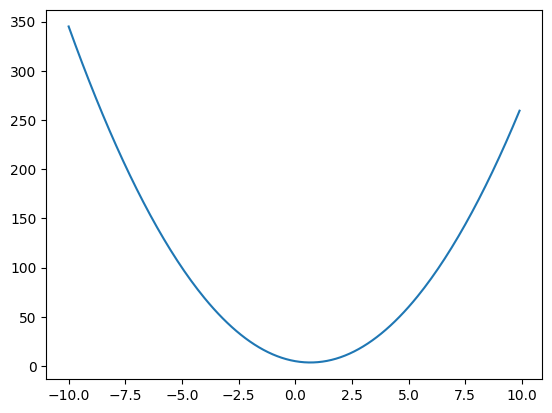

In [3]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)

Let's understand what the derivative of this function means. The derivative f'(x) gives us the slope of the tangent line to the curve at any point x. It tells us how fast the function is changing at that point.

In [4]:
h = 1e-5  # A small value for numerical differentiation
x = 2/3
(f(x + h) - f(x)) / h

3.0000002482211127e-05

Let's look at a bit more complex case.
The output variable 'd' below is a function of three scalars.

In [5]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [6]:
h = 1e-4

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1) / h)

d1:  4.0
d2:  3.999699999999999
Slope:  -3.000000000010772


The slope, given above by (d2 - d1)/h is how much the function increased when we increased x by a small amount h. This is the essence of numerical differentiation.

In [7]:
h = 1e-4

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.0002
Slope:  2.0000000000042206


In [8]:
h = 1e-4

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.0001
Slope:  0.9999999999976694


## Now let's start diving into the neural network part of the problem.

In [9]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

a = Value(2.0)
a

Value(data=2.0)

Value class is a simple wrapper around a scalar value. It allows us to create objects that can hold a single scalar value.
Python internally uses the `__repr__` method to define how an object is represented as a string. This is useful for debugging and logging purposes.

In [10]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
print('d: ', d)
d._prev

d:  Value(data=4.0)


{Value(data=-6.0), Value(data=10.0)}

In [11]:
d._op

'+'

In [12]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    # Build the graph
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # Create node label
        label = f"{{data {n.data:.4f}}}"
        dot.node(name=uid, label=label, shape='record')
        
        if n._op:
            # Add operation node
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


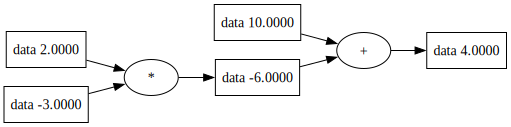

In [13]:
draw_dot(d)